# Lecture VIII: Random numbers

This lecture is mainly from "Numerical Recipes in C". The older versions of this textbook are freely available. Codes reported from the textbook are copytight of them.


**Uniform deviates** are just random numbers that lie within a specified range
(typically 0 to 1), with **any one number in the range just as likely as any other**. 

System call:
<code>
    x = rand()/(RAND_MAX+1.0);
    </code>
    
System-supplied `rand()`s are almost always linear congruential generators, which generate a sequence of integers I1, I2, I3, . . ., each between 0 and m − 1 (e.g., RAND_MAX) by the recurrence relation
<code>
    Ij+1 = aIj + c (mod m)
    </code>
    
Example:
    <code>
        unsigned long next=1;
        int rand(void) /* NOT RECOMMENDED (see text) */
          {
            next = next * 1103515245 + 12345;
            return (unsigned int)(next/65536) % 32768;
          }
        void srand(unsigned int seed)
          {
            next=seed;
          }
    </code>
    
Problems:

It has the disadvantage that it is **not free of sequential correlation on successive calls**. If k random numbers at a time are used to plot points in k dimensional space (with each coordinate between 0 and 1), then the points will not tend to “fill up” the k-dimensional space, but rather will *lie on (k − 1)-dimensional “planes.”*

There will be at most about m1/k such planes. If the constants m, a, and c are not very carefully chosen, there will be many fewer than that. **If m is as bad as 32768**, then the number of planes on which triples of points lie in three-dimensional space will be no greater than about the cube root of 32768, or **32**. Even if m is close to the machine’s largest representable integer, e.g., ∼ 2^32, the number of planes on which triples of points lie in three-dimensional space is usually no greater than about the cube root of 2^32, about **1600**. You might well be focusing attention on a physical process that occurs in a small fraction of the total volume, so that the discreteness of the planes can be very pronounced.

Other problem: **equipartition**. If you divide your interval in, say, 10 equispaced sub-intervals, each of them should statistically contains the same number of random numbers. System 'rand()' does not ensure this to happen.

Numerical Recipes' generator suffer *less* of this problem. Here is the list:


In [ ]:
#include <stdlib.h> 
#include <math.h>

#define MBIG 1000000000
#define MSEED 161803398
#define MZ 0
#define FAC (1.0/MBIG) /* According to Knuth, any large MBIG, and any smaller (but still large) MSEED can 
                          be substituted for the above values.*/


float ran3(long *idum) /*Returns a uniform random deviate between 0.0 and 1.0. Set idum to any negative value to
                         initialize or reinitialize the sequence. */
{
    static int inext,inextp;
    static long ma[56];  /* The value 56 (range ma[1..55]) is special and */
    static int iff=0;    /* should not be modified; see Knuth. */
    long mj,mk;
    int i,ii,k;
    if (*idum < 0 || iff == 0) /*Initialization.*/
      {
        iff=1;
        mj=labs(MSEED-labs(*idum)); /* Initialize ma[55] using the seed idum and the */
        mj %= MBIG;                 /* large number MSEED. */
        ma[55]=mj;
        mk=1;
        for (i=1;i<=54;i++)  /*Now initialize the rest of the table, */
          {
            ii=(21*i) % 55;  /*in a slightly random order,*/
            ma[ii]=mk;       /* with numbers that are not especially random. */
            mk=mj-mk;
            if (mk < MZ) mk += MBIG;
            mj=ma[ii];
          }
        for (k=1;k<=4;k++)   /* We randomize them by “warming upthe generator" */
          for (i=1;i<=55;i++) 
            {
              ma[i] -= ma[1+(i+30) % 55];
              if (ma[i] < MZ) ma[i] += MBIG;
            }
        inext=0;         /*Prepare indices for our first generated number.*/
        inextp=31;       /*The constant 31 is special; see Knuth.*/
        *idum=1;
      }
/*Here is where we start, except on initialization. */
if (++inext == 56) inext=1;   /* Increment inext and inextp, wrapping around*/
if (++inextp == 56) inextp=1; /* 56 to 1.*/
mj=ma[inext]-ma[inextp];      /* Gerate a new random number subtractively. */
if (mj < MZ) mj += MBIG;      /* Be sure that it is in range.*/
ma[inext]=mj;                 /* Store it, */
return mj*FAC;                /* and output the derived uniform deviate. */
}

Numerical's ran3() is good enough for a number of applications.

## Transformation Method: Exponential and Normal Deviates

### Theory

In the previous section, we learned how to generate random deviates with a uniform probability distribution, so that the probability of generating a number between x and x + dx, denoted p(x)dx, is given by

~~~text
    p(x)dx = dx         0 < x < 1
    0                   otherwise          (7.2.1)
~~~
The probability distribution p(x) is of course normalized, so that
~~~text
    int(-∞, ∞ ) p(x)dx = 1                 (7.2.2)
~~~
Now suppose that we generate a uniform deviate x and then take some prescribed function of it, `y(x)`. The probability distribution of y, denoted `p(y)dy`, is determined by the fundamental transformation law of probabilities, which is simply

~~~text
    |p(y)dy| = |p(x)dx|                     (7.2.3)
~~~
or
~~~text
    p(y) = p(x) |dx/dy|                     (7.2.4)
~~~

**This formula can be used to convert an uniform deviate in whatever *differentiable* other deviate**.

In fact, let’s see what is involved in using the above transformation method to generate some arbitrary desired distribution of y’s, say one with `p(y) = f(y)` for some positive function f whose integral is 1. According to (7.2.4), we need to solve the differential equation

~~~text
    dx/dy= f(y)                            (7.2.6)
~~~

But the solution of this is just `x = F(y)`, where `F(y)` is the indefinite integral of `f(y)`. The desired transformation which takes a uniform deviate into one distributed as f(y) is therefore

~~~text
    y(x) = F^−1(x)                          (7.2.7)
~~~
where `F^−1` is the **inverse function to F**. Whether (7.2.7) is feasible to implement depends on whether the inverse function of the integral of f(y) is itself feasible to compute, either analytically or numerically

Remember that the inverse function of a function is that for which:
~~~text
    F^-1[ F(x) ] = 1
~~~
Note also that, for `p(x)` to be a probability, its `F(x)` must be **normalized** to one (see below).

Here we have two examples:


### Exponential Deviates

As an example, suppose that `y(x) ≡ −ln(x)`, and that p(x) is as given by equation (7.2.1) for a uniform deviate. Then

~~~text
    p(y)dy = |dx/dy|dy = exp(−y)dy              (7.2.5)
~~~
which is distributed exponentially. This exponential distribution occurs frequently in real problems, usually as the distribution of waiting times between independent Poisson-random events, for example the radioactive decay of nuclei. You can also easily see (from 7.2.4) that the quantity `y/λ` has the probability distribution `λexp(−λy)`.

Note that `-ln(x)` is the inverse function of `exp(-x)`. 


### Normal (Gaussian) Deviates

Transformation methods generalize to more than one dimension. If x 1, x2, ... are random deviates with a joint probability distribution p(x1, x2, ...)dx1dx2 ... , and if y1, y2, . . . are each functions of all the x’s (same number of y’s as x’s), then the joint probability distribution of the y’s is

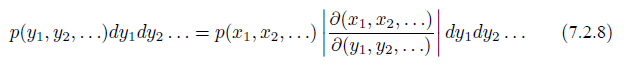

where |∂( )/∂( )| is the Jacobian determinant of the x’s with respect to the y’s (or reciprocal of the Jacobian determinant of the y’s with respect to the x’s).

An important example of the use of (7.2.8) is the **Box-Muller method** for generating random deviates with a **normal (Gaussian) distribution,**

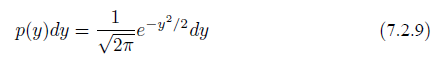

Consider the transformation between two uniform deviates on (0,1), x1, x2, and two quantities y1, y2,

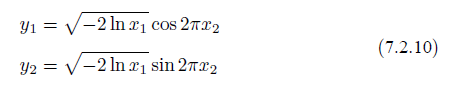

Equivalently we can write:

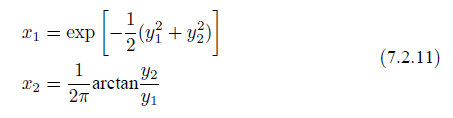

Now the Jacobian determinant can readily be calculated (try it!):

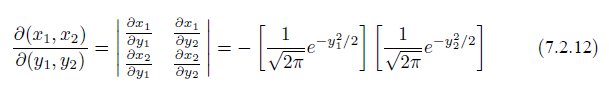

Since this is the product of a function of y2 alone and a function of y1 alone, we see that each y is independently distributed according to the normal distribution (7.2.9).

One further trick is useful in applying (7.2.10). Suppose that, instead of picking uniform deviates x1 and x2 in the unit square, we instead pick v1 and v2 as the ordinate and abscissa of a random point inside the unit circle around the origin. Then
the sum of their squares, **R^2 ≡ v1^2+v2^2** is a uniform deviate, which can be used for x1, while the angle that (v1, v2) defines with respect to the v1 axis can serve as the random angle 2πx2. What’s the advantage? It’s that the cosine and sine in (7.2.10) can now be written as **v1/√R^2** and **v2/√R^2**, obviating the trigonometric function calls (remember that trigonometric function calls are **slow**)!

Here you have Numerical's code for Gaussian numbers: 

In [ ]:
float gasdev(long *idum) /*Returns a normally distributed deviate with zero mean and unit variance, 
                           using ran3(idum) as the source of uniform deviates. */
{
float ran3(long *idum);
static int iset=0;
static float gset;
float fac,rsq,v1,v2;

if (*idum < 0) iset=0; /* Reinitialize.*/
if (iset == 0)         /* We don’t have an extra deviate handy, so */
 {
    do 
     {
        v1=2.0*ran3(idum)-1.0;     /* pick two uniform numbers in the square */
        v2= 2.0*ran3(idum)-1.0;    /* extending from -1 to +1 in each direction, */
        rsq=v1*v1+v2*v2;           /* see if they are in the unit circle, */
     } while (rsq >= 1.0 || rsq == 0.0);    /* and if they are not, try again. */
    fac=sqrt(-2.0*log(rsq)/rsq); /* Now make the Box-Muller transformation to get two normal deviates. Return one and */
                                 /* save the other for next time. */
    gset=v1*fac;
    iset=1;                      /* Set flag. */
    return v2*fac;
 } 
else 
 {                          /* We have an extra deviate handy, */
    iset=0;                 /* so unset the flag, */
    return gset;            /* and return it. */
 }
}


### Uniform point distributions in circles and spheres

One useful application of (7.2.7) is to get *numbers uniformly distributed in a sphere or a circle* without generating them in a square or cube and throw away those that are in the circle or sphere.

We generate the circle in polar coordinates. Remember that :
~~~text
    dxdy -> 2 PI R dR dphi
~~~
We thus can generate points by getting R, phi instead that x,y. But while phi is uniformly distributer, R is **linearly distributed**. Thus we need to use (7.2.7): for having R linearly distributed, we get an x uniformly ditributed. The indefinite integral of `RdR` is `1/2 R^2`; its inverse is `sqrt(2x)`.

But note that, due to the **normalization requirement**, `F(R) = int(0,1) R dR` must be **multiplied by two** and thus is 
`F(R)= R^2`. Thus `F^-1(x)` is *not* `sqrt(2x)` but simply `sqrt(x)`. **This holds for every power-law distributed random variable**.

So `R=sqrt(rand(x))`, `phi=2*pi*rand(x)` will generate points uniformly distributed in a circle :

    #include "stdlib.h"
    #include "stdio.h"
    #include "math.h"
    main(int argc, char *argv[])
      {
         int i, n;
         double R,phi;
         n=atoi(argv[1]);
         for(i=0;i<n;i++)
           {
             R = sqrt(rand()/(RAND_MAX+1.));     
             phi = 2*M_PI*rand()/(RAND_MAX+1.);
             printf("%lf %lf\n", R*cos(phi), R*sin(phi));
           }
      }

The same will hold for points uniformly distributed in a **sphere**. In this case:

~~~text
      dx dy dz -> 2 PI R^2 dR dphi dcos(theta)
~~~

So we will need three random number:
~~~text
       x uniform in [0, 2pi) (for phi)
       y uniform in [-1,1)   (for cos(theta) )
       z distributed as R^2
~~~

to get `z`: `F(R)= 1/3 R^3` (but must be multiplied by 3), thus `z=pow(rand()/(RAND_MAX+1), 1./3.)`. Try to write the code. Plot the result!


